**Section 1:- Setup and Installations**

This initial section prepares the environment for the entire benchmarking process. It runs a pip install command to download and install all required Python libraries, such as transformers, torch, accelerate, and radon. After the installations are complete, it imports all necessary modules, making them available for the subsequent sections.


In [2]:
# --- Section 1: Setup & Installations ---
print("Installing required libraries...")


!pip install --quiet --no-deps transformers torch accelerate bitsandbytes huggingface_hub radon ipywidgets matplotlib seaborn



# Import necessary modules
import ipywidgets as widgets
from IPython.display import display, HTML
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import notebook_login
import ast, re, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze

print("\nSetup Complete! ✅ (All dependencies loaded successfully)")


Installing required libraries...

Setup Complete! ✅ (All dependencies loaded successfully)


**Give your Huggingface Token here.**

In [3]:
from huggingface_hub import login

# Paste your Hugging Face token here (keep it private!)
login(token="hf_Token")


**Section 2 :- Configuration & Backend Engine**

This cell defines the core logic of the application. It's split into two main parts: Model Configuration: A dictionary named MODELS_TO_TEST is defined here, allowing you to easily specify which models from the Hugging Face Hub you want to benchmark. It also sets the computation device to "cuda" if a GPU is available, or "cpu" otherwise.

Helper & Generation Functions: This part contains several crucial functions:

clean_generated_code(): Removes model-specific formatting and extracts the pure Python code from the raw output.

is_syntactically_valid(): Uses Python's ast module to check if the generated code is free of syntax errors.

calculate_advanced_metrics(): Calculates Cyclomatic Complexity, Maintainability Index, and Lines of Code for syntactically valid code.

generate_code(): The main function that formats the prompt, sends it to the model, times the generation process, and returns the cleaned code and generation time.

In [4]:
# --- Model Configuration ---
MODELS_TO_TEST = {
    "DeepSeek-Coder-1.3B": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2-2.7B": "microsoft/phi-2",
    "Gemma-2B-IT": "google/gemma-2b-it",
    }
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Helper & Generation Functions ---
def clean_generated_code(text, model_path):
    model_path = model_path.lower()
    if "gemma" in model_path: text = re.sub(r"<start_of_turn>user\n.*<end_of_turn>\n<start_of_turn>model\n", "", text, flags=re.DOTALL).replace("<end_of_turn>", "")
    elif "phi-2" in model_path: text = re.sub(r"Instruct:.*\nOutput:", "", text, flags=re.DOTALL)
    else: text = re.sub(r"### Instruction:\n.*\n\n### Response:", "", text, flags=re.DOTALL)
    match = re.search(r"```python\n(.*?)\n```", text, re.DOTALL)
    if match: text = match.group(1)
    return text.strip()

def is_syntactically_valid(code_string: str) -> bool:
    if not code_string: return False
    try: ast.parse(code_string); return True
    except SyntaxError: return False

def calculate_advanced_metrics(code_string):
    if not is_syntactically_valid(code_string):
        return {"complexity": None, "maintainability": None, "loc": None}
    try:
        complexity = sum([c.complexity for c in cc_visit(code_string)]) if cc_visit(code_string) else 0
        maintainability = mi_visit(code_string, multi=True)
        loc = analyze(code_string).loc
        return {"complexity": complexity, "maintainability": round(float(maintainability), 2), "loc": loc}
    except: return {"complexity": None, "maintainability": None, "loc": None}

def generate_code(model, tokenizer, prompt):
    model_path = model.name_or_path.lower()
    if "gemma" in model_path: formatted_prompt = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    elif "phi-2" in model_path: formatted_prompt = f"Instruct: {prompt}\nOutput:"
    else: formatted_prompt = f"### Instruction:\n{prompt}\n\n### Response:"
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(formatted_prompt, return_tensors="pt", return_attention_mask=True).to(device)
    start_time = time.time()
    output_ids = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=512, temperature=0.1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
    end_time = time.time()

    raw_output = tokenizer.batch_decode(output_ids)[0]
    cleaned_code = clean_generated_code(raw_output, model_path)

    return {"code": cleaned_code, "gen_time": end_time - start_time}

print("Backend engine with advanced metrics is ready.")

Backend engine with advanced metrics is ready.


**Section 3 :- Pre-Loading All AI Models**


To ensure that the benchmarking process is efficient and measures only the code generation time, this section pre-loads all models specified in the MODELS_TO_TEST dictionary into memory. It iterates through each model, downloads its weights and tokenizer from the Hugging Face Hub, and stores them in a loaded_models dictionary for quick access later. This step can be time-consuming depending on the size of the models.

In [5]:
loaded_models = {}
print("Starting to pre-load all models...")
for model_name, model_path in MODELS_TO_TEST.items():
    print(f"\n--- Loading {model_name}... ---")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True)
        loaded_models[model_name] = {"model": model, "tokenizer": tokenizer}
        print(f"✅ {model_name} loaded successfully.")
    except Exception as e:
        print(f"✗ FAILED to load {model_name}. Error: {e}")
print("\n" + "="*50 + "\nAll available models are pre-loaded.\n" + "="*50)

Starting to pre-load all models...

--- Loading DeepSeek-Coder-1.3B... ---


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

✅ DeepSeek-Coder-1.3B loaded successfully.

--- Loading Phi-2-2.7B... ---


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Phi-2-2.7B loaded successfully.

--- Loading Gemma-2B-IT... ---


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Gemma-2B-IT loaded successfully.

All available models are pre-loaded.


**Section 4 :- UI #1 - Benchmark All Models**


This section introduces the first interactive user interface for basic benchmarking. It consists of:

1)A Textarea for entering a single coding prompt.

2)A Run Benchmark button to start the process.

3)An Output area to display the results.

When the button is clicked, the notebook runs the prompt on every pre-loaded model and displays a pandas DataFrame comparing their generated code, generation time, and all calculated code quality metrics.

In [6]:
# --- Section 4: UI #1 - Run All Models ---
print("--- UI #1: Benchmark All Models ---")
all_results_log = [] # Global log to store all results from both UIs

prompt_input_all = widgets.Textarea(placeholder='Enter a prompt to benchmark all models...', layout={'width': '95%'})
run_all_button = widgets.Button(description='Run Benchmark', button_style='danger', icon='rocket')
output_all = widgets.Output(layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll'})

def on_run_all_clicked(b):
    with output_all:
        prompt = prompt_input_all.value
        if not prompt: print("Please enter a prompt."); return

        print(f"Running prompt on {len(loaded_models)} models...")
        results_this_run = []
        for model_name, components in loaded_models.items():
            print(f"  - Generating with {model_name}...")
            result = generate_code(components['model'], components['tokenizer'], prompt)
            metrics = calculate_advanced_metrics(result['code'])

            entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
            results_this_run.append(entry)
            all_results_log.append(entry)

        print("\n--- Benchmark Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

run_all_button.on_click(on_run_all_clicked)
display(widgets.VBox([prompt_input_all, run_all_button, output_all]))

--- UI #1: Benchmark All Models ---


**Section 5 :- UI #2 - Inspect Models with Checkboxes**


This is a more advanced UI designed for flexible and multi-prompt testing. Its features include:

A larger Textarea that accepts up to 10 different prompts, each on a new line.

A series of Checkbox widgets, one for each loaded model, allowing you to select which ones to include in the run.

A Run Selected button that triggers the benchmark for every selected prompt-model combination.

This UI is ideal for more targeted testing or for evaluating how different models perform on a variety of tasks in a single run.

In [7]:
print("\n\n--- UI #2: Inspect Selected Models (Multi-Prompt Version) ---")

# Text area for multiple prompts
prompt_input_selected = widgets.Textarea(
    placeholder='Enter up to 10 prompts, each on a new line...',
    layout={'width': '95%', 'height': '150px'}
)

run_selected_button = widgets.Button(
    description='Run Selected',
    button_style='success',
    icon='play'
)

output_selected = widgets.Output(
    layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll'}
)

# Checkboxes for selecting models
model_checkboxes = {name: widgets.Checkbox(value=True, description=name) for name in loaded_models.keys()}
checkbox_container = widgets.VBox(list(model_checkboxes.values()))

# Button click event
def on_run_selected_clicked(b):
    with output_selected:
        output_selected.clear_output(wait=True)
        prompts_raw = prompt_input_selected.value.strip()
        if not prompts_raw:
            print("Please enter one or more prompts.")
            return

        # Split by line and take up to 10 prompts
        prompts = [p.strip() for p in prompts_raw.splitlines() if p.strip()]
        if not prompts:
            print("No valid prompts found.")
            return
        if len(prompts) > 10:
            print("Warning: Only the first 10 prompts will be used.")
            prompts = prompts[:10]

        models_to_run = [name for name, cb in model_checkboxes.items() if cb.value]
        if not models_to_run:
            print("Please select at least one model.")
            return

        print(f"Running {len(prompts)} prompts on {len(models_to_run)} selected models...\n")

        results_this_run = []

        # Run each prompt through each model
        for idx, prompt in enumerate(prompts, 1):
            print(f"\nPrompt {idx}: {prompt}\n")
            for model_name in models_to_run:
                print(f"  - Generating with {model_name}...")
                components = loaded_models[model_name]
                result = generate_code(components['model'], components['tokenizer'], prompt)
                metrics = calculate_advanced_metrics(result['code'])

                entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
                results_this_run.append(entry)
                all_results_log.append(entry)

        print("\n--- Multi-Prompt Run Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

# Attach event handler
run_selected_button.on_click(on_run_selected_clicked)

# Build and display UI
ui_selected_models = widgets.VBox([
    widgets.HTML("<h4>Enter up to 10 prompts (one per line):</h4>"),
    prompt_input_selected,
    widgets.HTML("<h4>Select models to run:</h4>"),
    checkbox_container,
    run_selected_button,
    output_selected
])

display(ui_selected_models)



--- UI #2: Inspect Selected Models (Multi-Prompt Version) ---


**Section 6 :- Final Analysis and Visualization Report**

After conducting one or more benchmark runs, this section allows you to generate a comprehensive report. Clicking the Generate Full Report & Plots button does two things:

It displays a complete pandas DataFrame containing all results logged during the session from both UIs.

It generates three comparative bar charts using matplotlib and seaborn to visually compare the models based on Generation Time, Cyclomatic Complexity, and Maintainability Index, making it easy to see which models perform best across these key metrics.

In [12]:
report_button = widgets.Button(description="Generate Full Report & Plots", button_style='info')
report_output = widgets.Output()

def on_report_button_clicked(b):
    with report_output:
        report_output.clear_output(wait=True)
        if not all_results_log:
            print("No results logged. Use one of the UIs above to generate code.")
            return

        df = pd.DataFrame(all_results_log).round(2)
        df.rename(columns={'complexity': 'Complexity', 'maintainability': 'Maintainability', 'gen_time': 'Gen Time (s)'}, inplace=True)

        print("--- Full Session Data ---")
        display(df)

        print("\n--- Comparative Plots ---")
        sns.set_theme(style="whitegrid")

        plot_df = df.dropna(subset=['Complexity', 'Maintainability'])

        if plot_df.empty:
            print("Not enough valid data to generate plots.")
            return

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle('Comparative Analysis of Code Metrics', fontsize=16)

        sns.barplot(ax=axes[0], data=plot_df, x='Model', y='Gen Time (s)', palette='viridis')
        axes[0].set_title('Generation Time (Lower is Faster)')
        axes[0].tick_params(axis='x', rotation=45)

        sns.barplot(ax=axes[1], data=plot_df, x='Model', y='Complexity', palette='magma')
        axes[1].set_title('Cyclomatic Complexity (Lower is Simpler)')
        axes[1].tick_params(axis='x', rotation=45)

        sns.barplot(ax=axes[2], data=plot_df, x='Model', y='Maintainability', palette='plasma')
        axes[2].set_title('Maintainability Index (Higher is Better)')
        axes[2].tick_params(axis='x', rotation=45)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

report_button.on_click(on_report_button_clicked)
print("\nUse the button below to generate the final report for the session.")
display(widgets.VBox([report_button, report_output]))


Use the button below to generate the final report for the session.


**Section 7: Qualitative Evaluation of Generated Code**

This section evaluates the quality and creativity of code generated by multiple preloaded AI models. It computes three key metrics for each model's output:

1) Logic Understanding (logic_score) – Measures the presence of programming constructs (like if, for, def) to assess how logically structured the code is.

2) Code Clarity (clarity_score) – Evaluates readability using common code symbols, spacing, and formatting cues.

3) Creativity / Novelty (creativity_score) – Uses TF-IDF and cosine similarity to compare each snippet against others; lower similarity indicates higher creativity.

The section also provides visualizations (bar plots) to compare models across these qualitative metrics, and integrates seamlessly with the preloaded models and your code generation pipeline from previous sections.

This allows for both human-understandable evaluation and side-by-side comparison of multiple models’ coding performance.

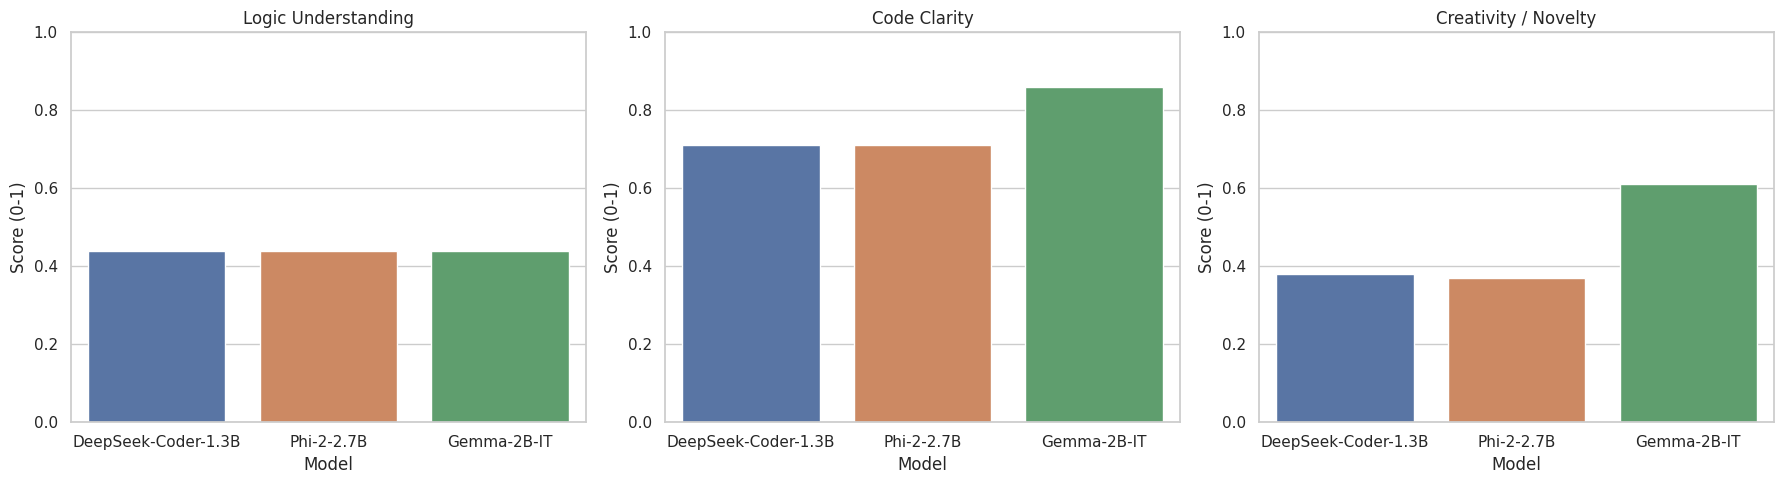

--- DeepSeek-Coder-1.3B ---
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

--- Phi-2-2.7B ---
```
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

print(factorial(5))
```
<|endoftext|>

--- Gemma-2B-IT ---
def factorial(n):
    """
    Calculates the factorial of a non-negative integer n recursively.

    Args:
        n: The non-negative integer whose factorial is to be calculated.

    Returns:
        The factorial of n.
    """

    # Base case: factorial of 0 is defined as 1.
    if n == 0:
        return 1

    # Recursive case: calculate the factorial of n by multiplying n with the factorial of (n-1).
    else:
        return n * factorial(n-1)


# Example usage:
n = 5
result = factorial(n)
print(f"The factorial of {n} is {result}")



In [11]:
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def qualitative_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds qualitative evaluation scores for model outputs.
    Expects a DataFrame with columns: ['Model', 'code'].
    Returns the same DataFrame with added columns:
    ['logic_score', 'clarity_score', 'creativity_score'].
    """
    logic_keywords = ["if", "else", "for", "while", "try", "except", "return", "def", "class"]
    readability_keywords = ["_", " ", "\n", "#", "=", "(", ")"]

    logic_scores, clarity_scores, creativity_scores = [], [], []

    codes = results_df["code"].fillna("").tolist()

    # TF-IDF vectors for semantic similarity
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(codes)
    sim_matrix = cosine_similarity(tfidf_matrix)

    for i, code in enumerate(codes):
        # --- Logic Score ---
        logic_score = sum(k in code for k in logic_keywords) / len(logic_keywords)
        logic_scores.append(round(logic_score, 2))

        # --- Clarity Score ---
        clarity_score = sum(k in code for k in readability_keywords) / len(readability_keywords)
        clarity_scores.append(round(clarity_score, 2))

        # --- Creativity Score ---
        # 1 - average similarity with all others (higher = more creative)
        avg_similarity = (np.sum(sim_matrix[i]) - 1) / (len(codes) - 1) if len(codes) > 1 else 0
        creativity_score = 1 - avg_similarity
        creativity_scores.append(round(creativity_score, 2))

    results_df["logic_score"] = logic_scores
    results_df["clarity_score"] = clarity_scores
    results_df["creativity_score"] = creativity_scores

    return results_df


def visualize_qualitative(results_df: pd.DataFrame):
    """
    Generates bar plots for logic, clarity, and creativity scores.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.barplot(data=results_df, x="Model", y="logic_score", ax=axes[0])
    sns.barplot(data=results_df, x="Model", y="clarity_score", ax=axes[1])
    sns.barplot(data=results_df, x="Model", y="creativity_score", ax=axes[2])
    
    axes[0].set_title("Logic Understanding")
    axes[1].set_title("Code Clarity")
    axes[2].set_title("Creativity / Novelty")
    
    for ax in axes:
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score (0-1)")
        ax.set_xlabel("Model")
    
    plt.tight_layout()
    plt.show()


# --- Example Integration with Preloaded Models ---
# Generate code from all preloaded models for a prompt
prompt = "Write a Python function to calculate factorial using recursion."
results = []

for model_name, objects in loaded_models.items():
    model, tokenizer = objects["model"], objects["tokenizer"]
    gen_output = generate_code(model, tokenizer, prompt)
    results.append({"Model": model_name, "code": gen_output["code"], "gen_time": gen_output["gen_time"]})

results_df = pd.DataFrame(results)

# Evaluate qualitatively
results_df = qualitative_metrics(results_df)
visualize_qualitative(results_df)

# Optionally, also view the generated codes
for idx, row in results_df.iterrows():
    print(f"--- {row['Model']} ---\n{row['code']}\n")


**Section 8:- (Optional) Manual Cleanup**

This final, optional cell provides a utility function to free up system resources. When run, it deletes all the loaded models and tokenizers from memory and then calls torch.cuda.empty_cache() to clear the GPU's VRAM. This is useful for avoiding memory errors if you plan to continue using the notebook for other tasks without restarting the kernel.

In [21]:

def clear_all_models():
    global loaded_models
    print(f"Clearing {len(loaded_models)} models from memory...")
    for model_name in list(loaded_models.keys()):
        del loaded_models[model_name]['model']
        del loaded_models[model_name]['tokenizer']
        del loaded_models[model_name]
    torch.cuda.empty_cache()
    print("\nAll models have been cleared from GPU memory.")

# To run the cleanup, uncomment and run the line below:
clear_all_models()

Clearing 1 models from memory...

All models have been cleared from GPU memory.
